### Problem 1 (50 points) 

Vapor-liquid equilibria data are correlated using two adjustable parameters $A_{12}$ and $A_{21}$ per binary
mixture. For low pressures, the equilibrium relation can be formulated as:

$$
\begin{aligned}
p = & x_1\exp\left(A_{12}\left(\frac{A_{21}x_2}{A_{12}x_1+A_{21}x_2}\right)^2\right)p_{water}^{sat}\\
& + x_2\exp\left(A_{21}\left(\frac{A_{12}x_1}{A_{12}x_1+A_{21}x_2}\right)^2\right)p_{1,4 dioxane}^{sat}.
\end{aligned}
$$

Here the saturation pressures are given by the Antoine equation

$$
\log_{10}(p^{sat}) = a_1 - \frac{a_2}{T + a_3},
$$

where $T = 20$($^{\circ}{\rm C}$) and $a_{1,2,3}$ for a water - 1,4 dioxane
system is given below.

|             | $a_1$     | $a_2$      | $a_3$     |
|:------------|:--------|:---------|:--------|
| Water       | 8.07131 | 1730.63  | 233.426 |
| 1,4 dioxane | 7.43155 | 1554.679 | 240.337 |


The following table lists the measured data. Recall that in a binary system $x_1 + x_2 = 1$.

|$x_1$ | 0.0 | 0.1 | 0.2 | 0.3 | 0.4 | 0.5 | 0.6 | 0.7 | 0.8 | 0.9 | 1.0 |
|:-----|:--------|:---------|:--------|:-----|:-----|:-----|:-----|:-----|:-----|:-----|:-----|
|$p$| 28.1 | 34.4 | 36.7 | 36.9 | 36.8 | 36.7 | 36.5 | 35.4 | 32.9 | 27.7 | 17.5 |

Estimate $A_{12}$ and $A_{21}$ using data from the above table: 

1. Formulate the least square problem; 
2. Since the model is nonlinear, the problem does not have an analytical solution. Therefore, solve it using the gradient descent or Newton's method implemented in HW1; 
3. Compare your optimized model with the data. Does your model fit well with the data?

---

### Problem 2 (50 points) 

Solve the following problem using Bayesian Optimization:
$$
    \min_{x_1, x_2} \quad \left(4-2.1x_1^2 + \frac{x_1^4}{3}\right)x_1^2 + x_1x_2 + \left(-4 + 4x_2^2\right)x_2^2,
$$
for $x_1 \in [-3,3]$ and $x_2 \in [-2,2]$. A tutorial on Bayesian Optimization can be found [here](https://thuijskens.github.io/2016/12/29/bayesian-optimisation/).





In [9]:
# Problem 1 : Least squares fitting for vapor-liquid equilibrium
import torch
import numpy as np
import matplotlib.pyplot as plt

SMOOTH = 1e-5


def model(X, A, p_sat):
    # Question : Temporary variables and the computational graph ...
    k1 = A[0]*(A[1]*X[1]/(A[0]*X[0] + A[1]*X[1]))
    k2 = A[1]*(A[0]*X[0]/(A[0]*X[0] + A[1]*X[1]))
    t1 = X[0]*torch.exp((k1**2))*p_sat[0]
    t2 = X[1]*torch.exp((k2**2))*p_sat[1]
    return t1 + t2


# Define the variables to be optimized over
A = torch.tensor([2.5,2.8], requires_grad = True, dtype = torch.float64)
# Data
X = np.asarray([np.arange(0,1.1,0.1), 1-np.arange(0,1.1,0.1)])
X = torch.from_numpy(X)
p = torch.tensor([28.1, 34.4, 36.7, 36.9, 36.8, 36.7, 36.5, 35.4, 32.9, 27.8, 17.5], requires_grad =  False, dtype = torch.float64)

# Constants
# a = torch.tensor([[8.07131, 1730.63, 233.426],[7.43155, 1554.679, 240.337]], requires_grad= False)
# T = 20
# p_sat_water = torch.tensor(a[0][0] - (a[0][1]/(T + a[0][2])))
# p_sat_dioxane = torch.tensor(a[1][0] - (a[1][1]/(T + a[1][2])))
p_sat = torch.tensor([1.2424, 1.4598], requires_grad = False, dtype = torch.float64)


def phi(alpha,X, A, p_sat):
    return model(X, A, p_sat) - alpha*0.8*np.dot(A.grad.detach().numpy(), A.grad.detach().numpy())


def line_search(X, A, p_sat):
    alpha = 0.001  # initialize step size
    while np.linalg.norm(np.nan_to_num(phi(alpha,X, A, p_sat).detach().numpy()))<np.linalg.norm(np.nan_to_num(model(X = X, A = A-alpha*A.grad, p_sat = p_sat).detach().numpy())):  # if f(x+a*d)>phi(a) then backtrack. d is the search direction
        # print("Backtracking...")
        alpha = 0.5*alpha
    return alpha

for i in range(500):
    # Define the loss function
    loss = torch.sum((p - model(X, A, p_sat))**2)
    loss.backward()
    alpha = line_search(X = X, A = A, p_sat = p_sat)
    print("Alpha:", alpha, "Loss:", loss.data.numpy(), "Gradient:", A.grad.numpy(), "Parameter:", A.data.numpy())

    with torch.no_grad():
        A -= alpha * A.grad
        A.grad.zero_()

p_final = model(X, A, p_sat)
print("Model: ", p_final)
print("Truth: ", p)


Alpha: 0.000125 Loss: 6840.552441569889 Gradient: [-2458.33436849 23546.32485182] Parameter: [2.5 2.8]
Alpha: 6.25e-05 Loss: 10072.124424619871 Gradient: [  -954.73109825 -40353.73088303] Parameter: [ 2.8072918  -0.14329061]
Alpha: 0.000125 Loss: 6590.524622143919 Gradient: [21120.45116334 -1607.73375507] Parameter: [2.86696249 2.37881757]
Alpha: 0.001 Loss: 11114.604939018514 Gradient: [-486.27510362  -18.00667792] Parameter: [0.22690609 2.57978429]
Alpha: 0.001 Loss: 10648.010382980063 Gradient: [-1384.63659663  -512.86488307] Parameter: [0.7131812  2.59779097]
Alpha: 7.8125e-06 Loss: 31115.564822620272 Gradient: [ 52720.8104526  227583.15263354] Parameter: [2.09781779 3.11065585]
Alpha: 0.001 Loss: 10600.82573460335 Gradient: [-587.87636133 -653.8134034 ] Parameter: [1.68593646 1.33266247]
Alpha: 0.0005 Loss: 8861.063653742518 Gradient: [-2957.30491927 -2560.30906072] Parameter: [2.27381282 1.98647588]
Alpha: 3.0517578125e-08 Loss: 66206786.88341682 Gradient: [6.80012867e+08 1.12998

/home/rrathnak/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:409: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
/home/rrathnak/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:506: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


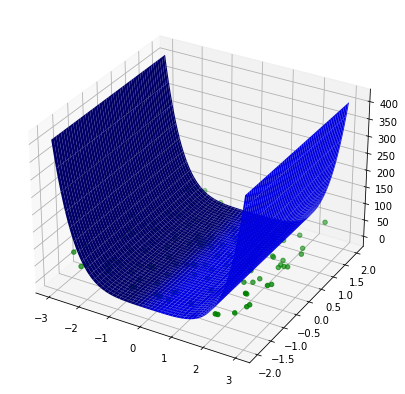

In [29]:
# Problem 2: Bayesian Optimization
import sklearn.gaussian_process as gp
import numpy as np
from scipy.stats import norm
from scipy.optimize import minimize
import matplotlib.pyplot as plt

from mpl_toolkits import mplot3d

def objective(x, mean = 0, var = 0.1):
    '''
    x : 2x1 vector of a sample in the domain of interest
    mean : scalar mean for iid noise term
    var : scalar variance for iid noise term
    '''
    noise = np.random.normal(mean, var)    
    return ((4 - (2.1*(x[0]**2)) + ((x[0]**4)/3))*(x[0]**2)) + (x[0]*x[1]) + ((-4 + 4*x[1]**2)*x[1]**2)




def expected_improvement(X_, X, model, k = 0.01):
    Y_mu, Y_sigma = model.predict(X, return_std = True)
    Y__= model.predict(X_)
    
    # Find the best value of predicted f(x) among the old samples
    with np.errstate(divide='ignore'):
        y_best = np.max(Y_sigma)
        Z = (Y_mu - y_best - k)/Y_sigma
        ei = ((Y_mu - y_best - k)*norm.cdf(Z)) + (Y_sigma*norm.pdf(Z))
        ei[Y_sigma == 0.0] = 0.0
    return X_[np.argmax(ei)]


# optimize the expected improvement
# EI function is highly non linear

x1 = np.random.uniform(-3,3,10)
x2 = np.random.uniform(-2,2,10)
X = np.asarray([[x1],[x2]]).transpose().squeeze(1)
Y = np.asarray([objective(x) for x in X])

kernel = gp.kernels.Matern()
model = gp.GaussianProcessRegressor(kernel=kernel,
                                    alpha=1e-4,
                                    n_restarts_optimizer=0,
                                    normalize_y=True)
n_iters = 100
k = 0.01
for i in range(n_iters):
    model.fit(X,Y)
    # Select next point using expected improvement
    x1 = np.random.uniform(-3,3,1000)
    x2 = np.random.uniform(-2,2,1000)
    X_ = np.asarray([[x1],[x2]]).transpose().squeeze(1)
    x_next = expected_improvement(X_ = X_, X = X, model = model)
    y_next = objective(x_next)
    X = np.vstack((X, x_next))
    Y = np.append(Y, y_next)

x1_bnds = np.linspace(-3,3, 100)
x2_bnds = np.linspace(-2, 2, 100)
x__ = np.asarray([[x1_bnds],[x2_bnds]]).transpose().squeeze(1)
x__, y__ = np.meshgrid(x1_bnds, x2_bnds)
z__ = np.asarray([objective(x__) for x in x__])

fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
ax.scatter3D(X[:,0], X[:,1], Y, color = "green")
ax.plot_surface(x__, y__, z__, color='blue')
